# Imports

In [1]:
import time
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from itertools import combinations

# langchain imports
from langchain.llms import Ollama, HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain_google_vertexai import VertexAI

from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams, LLMTestCase


# traditional ML imports
from scipy.stats import ttest_ind, zscore
from summarytools import dfSummary

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/deepeval/__init__.py:53: UserWarning: You are using deepeval version 2.4.9, however version 2.5.3 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


In [2]:
# finds .env file and loads the vars
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY", "Key not found")
openai_org = os.getenv("OPENAI_ORG", "Organization not found")

In [3]:
models = {
    "Gemini": VertexAI(model="gemini-2.0-flash-001"),
    "Palm": VertexAI(model="chat-bison"),
    "Mistral": Ollama(model="mistral"),
    "Gemma": Ollama(model="gemma"),
    # TODO: check if llama3 will be fast enough and substitute?
    "Llama": Ollama(model="llama3"),
    "Phi": Ollama(model="phi"),
}

Non-Gemini models are deprecated. They will be remoced starting from Dec-01-2024. 
/var/folders/3t/kmc2zb1d3tzd8k5p3ysx7p6c0000gp/T/ipykernel_60571/2026947131.py:4: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  "Mistral": Ollama(model="mistral"),


# Initialization

In [4]:
READ_FROM_PICKLE = True

In [5]:
if READ_FROM_PICKLE:
    malicious_df = pd.read_pickle("data/malicious_features_numeric.pkl")
    benign_df = pd.read_pickle("data/benign_features_numeric.pkl")

# EDA

## Statistical

In [6]:
def summarize_dataset(df):
    summary = f"""
    The dataset contains {len(df)} rows and it contains a network packet capture that was generated using Wireshark in an enterprize network.
    Study the first 100 rows of the dataset and try to understand what it describes:\n {df.head(100)}"
    Below are the summary statistics of the dataset\n {df.describe()}.
    """
    with open("data/df_summary_mal.txt", "r") as f:
        summary += f"A summary that includes statistics, histograms is given below \n {f.read()}." 
    summary += "Identify any anomalies in this time series dataset. Justify your conclusions based on known detections and security attacks." 
    return summary

In [7]:
dfSummary(malicious_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Timestamp[float64],Mean (sd) : 1540450214.8 (2080.2)min < med < max:1540446382.9 < 1540450432.6 < 1540453519.8IQR (CV) : 3618.0 (740512.8),"154,090 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAjtJREFUeJzt3btu4kAYhuExOcgbECMOCxeQMh0SDReQMhebS0hBsTXFNlvRISHLCCdWjHFklEhpkPB4E/NN3qcNf4bihVHCLxEURWGAc9dq+gkAp7g86VHACYIg+GWMuTZuXouieDn2Q0L1TFAvlvKG3TvOhv1+/95a23YZ3mw2URAEj8diJVTPIh0MBg/dbrdXdTbP86skSW47nc6/VquVVZ3Psiw0xtxNp9M/w+FwU2U2juNwPp/31ut1+QIj1B/guox0Npu9WGvTKoPL5bK3WCx+TyaTv+PxOKp68Pv8TRiG2Wg0eq46b4wpb4KjCNWvq7u73++vrLVR1ViiKDqE0m63U5fQPua/CqF6cnV/XL95nt+lafpkjHF5VztbhOrJ1f35+t3tdhfGM4R6hspIz/H6bRL/8IcEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUfH6E2uIhbd17x7MP2k+OZPzfUJhdx68yrnu3z9tNXv6M2vYjrNK96ts/bT9+yPeWyzfO/FnFd5lXP9nn7qS7+mIIEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoU/3y4dx3FY9Rdvt9vDTJIk4Wq1uvnOedWzVZ+3qTl/Sl9vM49G1TR9R5EAAAAASUVORK5CYII="">",0(0.0%)
2,Source Port[float64],Mean (sd) : 31461.6 (18801.8)min < med < max:0.0 < 32761.0 < 65267.0IQR (CV) : 28964.0 (1.7),"22,952 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAn9JREFUeJzt3LuO2kAARuEZbvICAiEU6GhSRkrhkofIw+YRUvAEFGlS0SEhC4R3EcY4chEpScHaHl/4veerdzQjcbxrxuuxSZIY4Nl1ml4AkEUv008hF2vtizFmUHD4NUmSt5KXJI9QK4h0Pp9/m0wmsyLjT6dTYK39Tqz/ItTyDdJI1+v123Q6veQZeDwevc1mMzscDulvY0L9C6FWJI10sVi8Fhia3jbgP3yZggRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRCRTv+cZr3f7TYln5eD0Pl/R8ttsWf13u/UXn/R8ugrZ9XpnemeP9Hy7SFnxdfpiCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCEh02l+H/BA26c+1PYjamWorgfaNnmobRzHfWPMxFpbZPjkfr/3G5q70ou7laG6HGjb5KG2YRj2oyj6ulqtut1uN/e6oyjy4jj+crlcfhhjXuucu+qLu62huh5o28ihttfrted53tD3/ctyuQzyjt/tdrPtdju83W7duueu+uJudaiqRqNRoQssCIKXpuau+uLmWz8kECokECokcI+K0jhubz3c2iJUlMJ1e+u9rS1CRSlctreybG1VGmoJTzrSe+h73U9oHNfuPLeyUfHtrYdbW71n/VOQhhKG4efxePyr0+lEdT2hcV2769yoOdSSnrJ88n3/Z97xLk9oXNfuOjccQk3vIUxO5/M595iyhWHo7ff7YRNrLzL3n3ld1x2KzZ2lr9+Vq4p5CUmM+AAAAABJRU5ErkJggg=="">",0(0.0%)
3,Destination Port[float64],Mean (sd) : 6758.4 (7691.4)min < med < max:23.0 < 8280.0 < 65267.0IQR (CV) : 10187.0 (0.9),"3,691 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAkNJREFUeJzt2EGO2jAYhmG7ZBAzahNBpCy5QKUeIPtu57Cz7a6LnIAbsEFIESSCgU5IXHn2VYkDGj7mffZ2vHhlfmydcwa4dV8++gDAOSJzRdbaR2PMeMAWb865wwWPBFHRNSNN0/Q5juNp6B51XW+stS/EimveqGMfaZ7nhyRJjn0XV1U1KYpiWpalv5EJ9ZO76k+/5yPNsuw1cLkfHYD/hzpgzoy7rnsIOxbQI9Qhc2bTNJO2bb8fj8ffxpjQGxU460YNnjOXy+V0sVg8nU6nUZ91QPCMGjJnbjYb5ktcDA/+kECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokBCZO2WtfTTGjAds8eacO1zwSBggutdI0zR9juN4GrpHXdcba+0Lsd6GuwzV36Q+0jzPD0mSHPsurqpqUhTFtCxLfyMT6g2411Df+UizLHsNXO5HB9wI/kxBAqFCAqFCwl3PqEO0bftgjImttVJPW3bYs9zNPslF5/4L7rvxbrd7X7Pf7yfr9fqp73r/zbZto8BY4q7ropBze6vV6lvTND/m8/loNBr1fjXYbrc7a+0vY0zvtQNNZrPZzyRJvoYs/sBze3+cc//87l+vnZg3NCraiwAAAABJRU5ErkJggg=="">",0(0.0%)
4,Payload[object],"1. Raw2. Padding3. 4. DNS Qry ""b'xmpp.samsungsmartca5. DNS Ans 6. DNS Qry ""b'xmpp.samsungsmartca7. DNS Qry ""b'10024backup.broadli8. DNS Qry ""b'10024main.broadlink9. DNS Qry ""b'www.baidu.com.'"" 10. DNS Qry ""b'authentication.eye411. other","64,960 (42.2%)28,136 (18.3%)22,577 (14.7%)7,099 (4.6%)4,561 (3.0%)3,550 (2.3%)2,216 (1.4

In [8]:
malicious_data_summary = summarize_dataset(malicious_df)
prompt_template = PromptTemplate(
    input_variables=["malicious_data_summary"],
    template="Analyze this dataset and identify anomalies and trends:\n{malicious_data_summary}",
)

In [9]:
malicious_data_summary

'\n    The dataset contains 154090 rows and it contains a network packet capture that was generated using Wireshark in an enterprize network.\n    Study the first 100 rows of the dataset and try to understand what it describes:\n         Timestamp  Source Port  Destination Port  \\\n0    1.540446e+09      21074.0              80.0   \n1    1.540446e+09      20532.0            8280.0   \n7    1.540446e+09       2440.0              53.0   \n8    1.540446e+09         53.0            2440.0   \n9    1.540446e+09      21074.0              80.0   \n..            ...          ...               ...   \n128  1.540446e+09      52259.0             443.0   \n130  1.540446e+09      47815.0              80.0   \n131  1.540446e+09      59225.0            8000.0   \n132  1.540446e+09      48977.0              80.0   \n133  1.540446e+09      50861.0           10240.0   \n\n                                               Payload  Packet Length  \\\n0                                              Padding  

In [10]:
statistical_results = {}

for model_name, model in models.items():
    print(f"Running analysis with {model_name}...")

    start_time = time.time()

    # Create chain and execute
    response = model.invoke(
        prompt_template.format(malicious_data_summary=malicious_data_summary)
    )

    end_time = time.time()

    # Store results
    statistical_results[model_name] = {
        "response": response,
        "time_taken": round(end_time - start_time, 2),
    }

    print(f"\n{model_name} Response:\n{response}\n")
    print(f"Time Taken: {round(end_time - start_time, 2)} seconds\n")

Running analysis with Gemini...

Gemini Response:
Okay, let's analyze this network packet capture data for anomalies and potential security implications.  I'll combine the information from the head of the data, the summary statistics, and the extended summary to build a comprehensive picture.

**Understanding the Data**

*   **Network Traffic:** The data represents individual network packets captured in an enterprise network. Each row describes a single packet.
*   **Key Features:**
    *   `Timestamp`:  When the packet was captured.
    *   `Source Port`, `Destination Port`:  The ports used for communication.  Important for identifying services and potential vulnerabilities.
    *   `Payload`:  A description of the packet's content.  Can indicate the type of data being transmitted (e.g., DNS queries, raw data, padding).
    *   `Packet Length`: The size of the packet.
    *   `Protocol`: TCP (6) or UDP (17).
    *   `src_ip_total_bytes`, `dst_ip_total_bytes`: Total bytes sent/received

### Hypothesis testing
- Is the difference between two groups or variables statistically significant?
- Use t-test to compare means of two groups
  - assumes that data follows normal distribution
- Types of variables
  - dependent: the effect of a phenomenon. For example, how does number of HTTP requests mean that a network is compromised?
  - independent: the cause. The number of HTTP requests affects whether a network is compromised.

In [11]:
malicious_df.pop("Payload")

0                                                   Padding
1                                                   Padding
7         DNS Qry "b'xmpp.samsungsmartcam.com.Speedport_...
8                                                  DNS Ans 
9                                                   Padding
                                ...                        
764121                                                  Raw
764122                      DNS Qry "b'time.windows.com.'" 
764124                                              Padding
764125                                              Padding
764136    DNS Qry "b'north-america.pool.ntp.org.Speedpor...
Name: Payload, Length: 154090, dtype: object

In [12]:
def hypothesis_testing(df, col1, col2):
    group1 = df[col1]
    group2 = df[col2]
    pvalue = ttest_ind(group1, group2)[1]
    if pvalue < 0.05:
        return "The difference between {} and {} is statistically significant (p < 0.05)".format(
            col1, col2
        )
    else:
        return "The difference between {} and {} is not statistically significant (p >= 0.05)".format(
            col1, col2
        )

In [13]:
def get_column_combinations(df):
    df_columns = df.columns.tolist()
    pairs = list(combinations(df_columns, 2))

    return pairs

In [14]:
def all_hypotheses(df):
    # perform hypothesis testing for all combinations of columns
    all_column_pairs = get_column_combinations(malicious_df)
    hypotheses = ""
    for pair in all_column_pairs:
        hypotheses += hypothesis_testing(df, pair[0], pair[1])
    # ask model to explain
    explain = f"""
    Below there is all the hypothesis testing performed with ttest for all the possible combinations of the features of the dataset. 
    Extract logical conclusions based on the hypotheses testings. 
    Is there a difference between two groups of variables that is statistically significant? 
    Can you conclude if there are dependent or independent variables in the dataset? \n ** Hypotheses Tests ** {hypotheses}
    """
    
    return explain 

In [15]:
hypotheses = all_hypotheses(malicious_df)
prompt_template = PromptTemplate(
    input_variables=["hypotheses"],
    template="Analyze this dataset based on the hypotheses tests and identify anomalies and trends:\n{hypotheses}",
)

In [16]:
hypotheses_results = {}

for model_name, model in models.items():
    print(f"Running analysis with {model_name}...")

    start_time = time.time()

    # Create chain and execute
    response = model.invoke(prompt_template.format(hypotheses=hypotheses))

    end_time = time.time()

    # Store results
    hypotheses_results[model_name] = {
        "response": response,
        "time_taken": round(end_time - start_time, 2),
    }

    print(f"\n{model_name} Response:\n{response}\n")
    print(f"Time Taken: {round(end_time - start_time, 2)} seconds\n")

Running analysis with Gemini...

Gemini Response:
Okay, let's analyze this hypothesis testing output and try to draw some conclusions.

**Understanding the Tests**

Each line represents a two-sample t-test comparing the means of two features from your dataset.  A t-test helps determine if there's a statistically significant difference between the averages of two groups (in this case, the values of two different features).

*   **p < 0.05:** This means the difference between the means of the two features is statistically significant at the 5% level. In simpler terms, there's a low probability that the observed difference is due to random chance. We reject the null hypothesis (that there's no difference).
*   **p >= 0.05:** This means the difference between the means of the two features is *not* statistically significant at the 5% level. We fail to reject the null hypothesis.

**General Observations**

*   **"Interarrival" is the odd one out:**  The feature "Interarrival" shows no statis

In [17]:
hypotheses

'\n    Below there is all the hypothesis testing performed with ttest for all the possible combinations of the features of the dataset. \n    Extract logical conclusions based on the hypotheses testings. \n    Is there a difference between two groups of variables that is statistically significant? \n    Can you conclude if there are dependent or independent variables in the dataset? \n ** Hypotheses Tests ** The difference between Timestamp and Source Port is statistically significant (p < 0.05)The difference between Timestamp and Destination Port is statistically significant (p < 0.05)The difference between Timestamp and Packet Length is statistically significant (p < 0.05)The difference between Timestamp and Protocol is statistically significant (p < 0.05)The difference between Timestamp and src_ip_total_bytes is statistically significant (p < 0.05)The difference between Timestamp and dst_ip_total_bytes is statistically significant (p < 0.05)The difference between Timestamp and Numer

### Outliers
- observation that significantly differs from others in a dataset
- Causes
  - measurement errors
  - extreme rare values
- significant impact in statistical analysis
- measurements
  - z-score: `(x - mean) / std_dev`
  - IQR method: this method identifies outliers as observations that are below `Q1 - 1.5IQR` or above `Q3 + 1.5IQR`, where Q1 and Q3 are the first and third quartiles, and IQR is the interquartile range (the difference between Q3 and Q1).
  - visual inspection

In [18]:
def detect_outliers_zscore(df, column, threshold=3):
    zscores = np.abs(zscore(df[column]))
    return df[zscores > threshold]

In [19]:
def all_outliers(df):
    outliers = ""
    for feature in df.columns:
        outliers += f"Outlier scores for {feature} are {detect_outliers_zscore(df, feature, threshold=3)}"
        # ask model to explain
    explain = f"Below there is all the outliers scores calculated using zscore, for all the possible combinations of the features of the dataset. Extract logical conclusions based on the outliers. Do you find any interesting observations that stand out in the dataset based on the outlier calculations? What are your conclusions? \n ** Outlier Scores ** {outliers}"

    return explain

In [20]:
outliers = all_outliers(malicious_df)
prompt_template = PromptTemplate(
    input_variables=["outliers"],
    template="Analyze this dataset based on the outlier calculations and identify anomalies and trends:\n{outliers}",
)

In [21]:
outliers_results = {}

for model_name, model in models.items():
    print(f"Running analysis with {model_name}...")

    start_time = time.time()

    # Create chain and execute
    response = model.invoke(prompt_template.format(outliers=outliers))

    end_time = time.time()

    # Store results
    outliers_results[model_name] = {
        "response": response,
        "time_taken": round(end_time - start_time, 2),
    }

    print(f"\n{model_name} Response:\n{response}\n")
    print(f"Time Taken: {round(end_time - start_time, 2)} seconds\n")

Running analysis with Gemini...

Gemini Response:
Based on the provided outlier analysis using z-scores, here's a breakdown of the findings and potential conclusions:

**Summary of Outlier Detections**

*   **Timestamp:** No outliers detected.
*   **Source Port:** No outliers detected.
*   **Destination Port:** Outliers detected (2211 rows).
*   **Packet Length:** Outliers detected (1542 rows).
*   **Protocol:** No outliers detected.
*   **src\_ip\_total\_bytes:** No outliers detected.
*   **dst\_ip\_total\_bytes:** Outliers detected (4090 rows).
*   **Numeric Source IP:** Outliers detected (27 rows).
*   **Numeric Destination IP:** No outliers detected.
*   **dst\_port\_freq\_encoded:** No outliers detected.
*   **Interarrival:** No outliers detected.

**Detailed Analysis & Potential Interpretations**

1.  **Destination Port Outliers:**
    *   The presence of outliers in the "Destination Port" feature suggests that certain destination ports are being accessed in a way that deviates s

In [22]:
outliers

'Below there is all the outliers scores calculated using zscore, for all the possible combinations of the features of the dataset. Extract logical conclusions based on the outliers. Do you find any interesting observations that stand out in the dataset based on the outlier calculations? What are your conclusions? \n ** Outlier Scores ** Outlier scores for Timestamp are Empty DataFrame\nColumns: [Timestamp, Source Port, Destination Port, Packet Length, Protocol, src_ip_total_bytes, dst_ip_total_bytes, Numeric Source IP, Numeric Destination IP, dst_port_freq_encoded, Interarrival]\nIndex: []Outlier scores for Source Port are Empty DataFrame\nColumns: [Timestamp, Source Port, Destination Port, Packet Length, Protocol, src_ip_total_bytes, dst_ip_total_bytes, Numeric Source IP, Numeric Destination IP, dst_port_freq_encoded, Interarrival]\nIndex: []Outlier scores for Destination Port are            Timestamp  Source Port  Destination Port  Packet Length  Protocol  \\\n342     1.540446e+09   

## Visualizations

In [23]:
eda_summary = summarize_dataset(malicious_df)    
prompt_template = PromptTemplate(
    input_variables=["eda_summary"],
    template=""" Given the following dataset summary statistics: 
    ### Summary statistics
    {eda_summary}
    Generate a Python script using Matplotlib and Seaborn to visualize:
    1. A time series plot of value over time,
    2. Highlight anomalies in the dataset,
    3. Suggest interesting trends
    """,
)

In [24]:
model_visualizations = {}
for model_name, model in models.items():
    print(f"Running analysis with {model_name}...")

    start_time = time.time()

    # Create chain and execute
    response = model.invoke(prompt_template.format(eda_summary=eda_summary))

    end_time = time.time()

    # Store results
    model_visualizations[model_name] = {
        "response": response,
        "time_taken": round(end_time - start_time, 2),
    }

    print(f"\n{model_name} Response:\n{response}\n")
    print(f"Time Taken: {round(end_time - start_time, 2)} seconds\n")

Running analysis with Gemini...

Gemini Response:
```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace with your actual data loading)
# Assuming the data is in a CSV file named 'network_traffic.csv'
# and already preprocessed according to your notebook
#df = pd.read_csv('network_traffic.csv')

# Create a sample DataFrame based on the summary
data = {
    'Timestamp': [1.540446e+09, 1.540446e+09, 1.540446e+09, 1.540446e+09, 1.540446e+09,
                  1.540446e+09, 1.540446e+09, 1.540446e+09, 1.540446e+09, 1.540446e+09],
    'Source Port': [21074.0, 20532.0, 2440.0, 53.0, 21074.0, 52259.0, 47815.0, 59225.0, 48977.0, 50861.0],
    'Destination Port': [80.0, 8280.0, 53.0, 2440.0, 80.0, 443.0, 80.0, 8000.0, 80.0, 10240.0],
    'Packet Length': [26, 26, 83, 83, 26, 40, 40, 40, 40, 48],
    'Protocol': [6.0, 6.0, 17.0, 17.0, 6.0, 6.0, 6.0, 6.0, 6.0, 17.0],
    'src_ip_total_bytes': [26, 52, 83, 83, 78, 324, 36

# Compare datasets

In [25]:
benign_data_summary = summarize_dataset(benign_df)
prompt_template = PromptTemplate(
    input_variables=["malicious_data_summary", "benign_data_summary"],
    template="Analyze the two input datasets that were taken by a network tap using wireshark, based on the summaries given below: \n Dataset1 Summary: {malicious_data_summary}\n Dataset2 Summary: {benign_data_summary}.\n What are the differences, what are the similarities between the two datasets? Can you identify if any of the two datasets exhibits malicious or benign behavior? Why? Give any other interesting observations that you extract from the two datasets.",
)

In [26]:
comparison_results = {}

for model_name, model in models.items():
    print(f"Running analysis with {model_name}...")

    start_time = time.time()

    # Create chain and execute
    response = model.invoke(
        prompt_template.format(
            malicious_data_summary=malicious_data_summary,
            benign_data_summary=benign_data_summary,
        )
    )

    end_time = time.time()

    # Store results
    comparison_results[model_name] = {
        "response": response,
        "time_taken": round(end_time - start_time, 2),
    }

    print(f"\n{model_name} Response:\n{response}\n")
    print(f"Time Taken: {round(end_time - start_time, 2)} seconds\n")

Running analysis with Gemini...

Gemini Response:
Okay, let's analyze these two network tap datasets and identify potential anomalies and differences.

**Dataset 1 Analysis:**

*   **General Overview:** This dataset represents network traffic in an enterprise environment, as indicated by the DNS queries for various services (Samsung SmartCam, Broadlink devices, Baidu, etc.) and the presence of common ports (80, 443, 53, 8000, 8280, 10240).

*   **Anomalies and Potential Malicious Behavior:**
    *   **"Padding" Payloads:** A significant portion of the traffic (18.3%) uses "Padding" payloads. While not inherently malicious, excessive padding can be used to obscure malicious data or bypass intrusion detection systems (IDS). This should raise a flag.
    *   **DNS Queries to Odd Domains:** The presence of DNS queries for `xmpp.samsungsmartcam.com`, `10024backup.broadlink`, `10024main.broadlink`, `www.baidu.com`, `authentication.eye4` is suspicious. Unless the enterprise is using those dev

# Evaluate EDA with LLMs

In [27]:
correctness_metric = GEval(
    name="Correctness",
    criteria="Determine whether the actual output is factually correct based on the expected output.",
    # NOTE: you can only provide either criteria or evaluation_steps, and not both
    evaluation_steps=[
        "Check whether the facts in 'actual output' contradicts any facts in 'expected output'",
        "You should give more points to the responses that are based on the logical analysis of numerical results.",
        "You should penalize responses that are lacking detailed explanations",
        "You should penalize responses that are contradictory to the ground truth",
        "Different numbers in the responses are OK, however contradicting opinions are not OK.",
    ],
    evaluation_params=[
        LLMTestCaseParams.INPUT,
        LLMTestCaseParams.ACTUAL_OUTPUT,
        LLMTestCaseParams.EXPECTED_OUTPUT,
    ],
)

In [28]:
summary_human_output = """1. The source ports seem to have some unusually high frequencies in higher values and the destination ports exhibit high variability. This may indicate scanning.
2. The payload indicates dns queries to domains that resemble IoT devices such as broadlink routers.
3. The packet lengths show an interesting distribution of some unusually high values that may point to exfiltration or malware download. 
4. There is unusually high activity in UDP protocol that may be suspicious of unusual services.
5. There is also some unusual high frequency in destination port 23 and 2323 that point to telnet and IoT telnet.
6. Finally the interarrival is unusually short, and that may indicate Denial of Service attack."""

In [29]:
hypotheses_human_output = """ Based on the hypothesis testing results:
1. All pairs of variables seem unrelated to statistically significant differences.
2. Logically, variables that should correlate are the bytes in/out and interarrival but there seems not to be any correlation.
3. The results are inconclusive and additional analysis may be needed.
"""

In [30]:
outliers_human_output = """ Based on the outliers calculations we reach the following conclusions:
1. There are some destination port outliers that may indicate abnormal malicious behavior.
2. There are outliers in packet size that again may point to unusual activity.
"""

In [31]:
statistics_correctness = {} 
for llm_item in statistical_results.items():
    test_case = LLMTestCase(
        input=malicious_data_summary,
        actual_output=llm_item[1]["response"],
        expected_output=summary_human_output,
    )

    correctness_metric.measure(test_case)
    correctness_dict = {}

    print(f"Model {llm_item[0]} response correctness: {correctness_metric.score}")
    print(correctness_metric.reason)
    statistics_correctness[llm_item[0]] =  correctness_metric.score

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Gemini response correctness: 0.7540937973709874
The actual output correctly identifies potential issues such as high destination port frequencies, DNS queries to IoT-related domains, and unusual UDP activity, consistent with expected output. It also discusses packet lengths, which was noted in expected output. However, it lacks detailed discussion on specific destination ports 23 and 2323 related to telnet, which are highlighted in the expected output. Overall, there are no contradictions, and the analysis is logically and numerically based.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Palm response correctness: 0.3815214688057842
There are no direct contradictions with expected anomalies but lacks the depth and multiple points of analysis expected. Actual output highlights high interarrival time and high source port values but misses other key observations from the expected output such as analysis on unusual payloads, packet lengths, and specific port activity. It somewhat covers interarrival time analysis but doesn't align fully with expectations.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Mistral response correctness: 0.5931081325109979
Actual output identifies several anomalies like unusual packet lengths, TCP and UDP distributions, and port usage which align with expected output. However, it misses specific points such as IoT-related DNS queries and Telnet ports, and misstates the TCP to UDP ratio opposite to the expected observation.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Gemma response correctness: 0.495725556334493
The actual output identifies anomalies largely consistent with expected output, like unusual UDP activity and interarrival time, indicating potential attacks. However, it contradicts the `expected output` in areas like source IP interpretation and doesn't cover IoT-specific details as mentioned.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Llama response correctness: 0.7308763024965974
The actual output aligns with the expected output in terms of identifying potential anomalies in high UDP traffic and DNS queries, indicating reconnaissance activities. However, it lacks detailed explanations on destination port activities and specific connections to known attacks outlined in the expected output.


Model Phi response correctness: 0.28740926416003243
The actual output lacks detailed analysis of numerical patterns and doesn't clearly identify anomalies in the dataset. It suggests potential data tampering from padding, but many expected output details like high port frequencies, specific protocols, and interarrival times indicating attacks are missing.


In [32]:
hypothesis_correctness = {}
for llm_item in hypotheses_results.items():
    test_case = LLMTestCase(
        input=malicious_data_summary,
        actual_output=llm_item[1]["response"],
        expected_output=hypotheses_human_output,
    )

    correctness_metric.measure(test_case)
    print(f"Model {llm_item[0]} response correctness: {correctness_metric.score}")
    print(correctness_metric.reason)
    hypothesis_correctness[llm_item[0]]  = correctness_metric.score

Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Gemini response correctness: 0.5156670414848394
The actual output identifies Interarrival as distinct, similar to the expected output which mentions no correlation; however, it provides more detailed analysis and insights, resulting in a logically sound but misaligned interpretation.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Palm response correctness: 0.3121848580982019
The actual output claims significant differences between features which contradicts the expected output's conclusion of no statistically significant differences. The level of logical analysis was okay, but the outlet of conclusions was contradictory to ground truth.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Mistral response correctness: 0.3447055910456583
The actual output correctly identifies significance in hypothesis tests and suggests looking for anomalies, but it incorrectly suggests relationships that are deemed unrelated in the expected output and lacks detailed numerical evidence.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Gemma response correctness: 0.43224156520646584
The actual output identifies statistically significant differences but does not clearly contradict the expected output that mentions no significant differences between variable pairs. However, the explanation lacks details on specific features and lacks explicit contradiction of provided expected output conclusions about a lack of correlation.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Llama response correctness: 0.3493006734500368
Actual Output incorrectly identifies many correlations while Expected Output finds variables unrelated. Both mention Interarrival as not correlated, but Actual Output's substantive analysis on correlation contradicts Expected Output's inconclusive results.


Model Phi response correctness: 0.3259558206298067
While the actual output identifies possible statistical differences, it does not match the expected output, which concludes unrelated variables with no statistical significance. There is a lack of detailed explanation on the correlation analysis leading to inconclusive results in expected output, which are not addressed in the actual output.


In [33]:
outlier_correctness = {}
for llm_item in outliers_results.items():
    test_case = LLMTestCase(
        input=malicious_data_summary,
        actual_output=llm_item[1]["response"],
        expected_output=outliers_human_output,
    )

    correctness_metric.measure(test_case)
    print(f"Model {llm_item[0]} response correctness: {correctness_metric.score}")
    print(correctness_metric.reason)
    outlier_correctness[llm_item[0]] = correctness_metric.score

Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Gemini response correctness: 0.6633442180105764
The actual output provides detailed analysis on anomalies with logical interpretations about potential security threats, but it lacks a concise summary like the expected output, focusing on specific outlier categories instead of overall abnormal behavior.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Palm response correctness: 0.7149887874832805
The actual output correctly identifies outliers in destination port and packet length, aligning with expected conclusions about potential anomalies. However, it lacks detailed explanation of how these outliers indicate abnormal or malicious behavior.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Mistral response correctness: 0.33250230122826985
The actual output lacks detailed analysis of the dataset's numerical results and anomalies, as shown in the expected output with conclusions on destination port and packet size outliers, indicating potential behavior. Definitions provided are not part of the core task evaluation.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Gemma response correctness: 0.3344975248307288
Actual output lacks detailed explanation on anomalies, contradictions with expected findings of abnormal port behaviors and packet sizes, and lacks logical analysis of numerical results for outlier detection.


Event loop is already running. Applying nest_asyncio patch to allow async execution...

/Users/xeniamountrouidou/sandbox/cyberdata-mlai/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Model Llama response correctness: 0.3064777868998291
The actual output lacks detailed explanations on anomalies, contradicts the expected output by stating no outliers exist for destination port and packet size, which the expected output identifies as potential indicators of malicious behavior.


Model Phi response correctness: 0.2098248236256967
The actual output fails to identify anomalies or relate them to potential security threats like the expected output which mentions destination port and packet size outliers.


In [34]:
all_scores = []
for model_name, score in statistics_correctness.items():
    score_dict = {}
    score_dict[model_name] = {
        "statistics_correctness": score,
        "hypothesis_correctness": hypothesis_correctness[model_name],
        "outlier_correctness": outlier_correctness[model_name],
    }
    all_scores.append(score_dict)

all_scores

[{'Gemini': {'statistics_correctness': 0.7540937973709874,
   'hypothesis_correctness': 0.5156670414848394,
   'outlier_correctness': 0.6633442180105764}},
 {'Palm': {'statistics_correctness': 0.3815214688057842,
   'hypothesis_correctness': 0.3121848580982019,
   'outlier_correctness': 0.7149887874832805}},
 {'Mistral': {'statistics_correctness': 0.5931081325109979,
   'hypothesis_correctness': 0.3447055910456583,
   'outlier_correctness': 0.33250230122826985}},
 {'Gemma': {'statistics_correctness': 0.495725556334493,
   'hypothesis_correctness': 0.43224156520646584,
   'outlier_correctness': 0.3344975248307288}},
 {'Llama': {'statistics_correctness': 0.7308763024965974,
   'hypothesis_correctness': 0.3493006734500368,
   'outlier_correctness': 0.3064777868998291}},
 {'Phi': {'statistics_correctness': 0.28740926416003243,
   'hypothesis_correctness': 0.3259558206298067,
   'outlier_correctness': 0.2098248236256967}}]

In [35]:
# Convert to long-format DataFrame
all_scores_df_long = pd.DataFrame(
    [
        {"Model": list(item.keys())[0], "Metric": metric, "Score": value}
        for item in all_scores
        for metric, value in list(item.values())[0].items()
    ]
)
all_scores_df_long.to_csv("all_scores_eda.csv", index=False)
all_scores_df_long

,Model,Metric,Score
0,Gemini,statistics_correctness,0.754094
1,Gemini,hypothesis_correctness,0.515667
2,Gemini,outlier_correctness,0.663344
3,Palm,statistics_correctness,0.381521
4,Palm,hypothesis_correctness,0.312185
5,Palm,outlier_correctness,0.714989
6,Mistral,statistics_correctness,0.593108
7,Mistral,hypothesis_correctness,0.344706
8,Mistral,outlier_correctness,0.332502
9,Gemma,statistics_correctness,0.495726


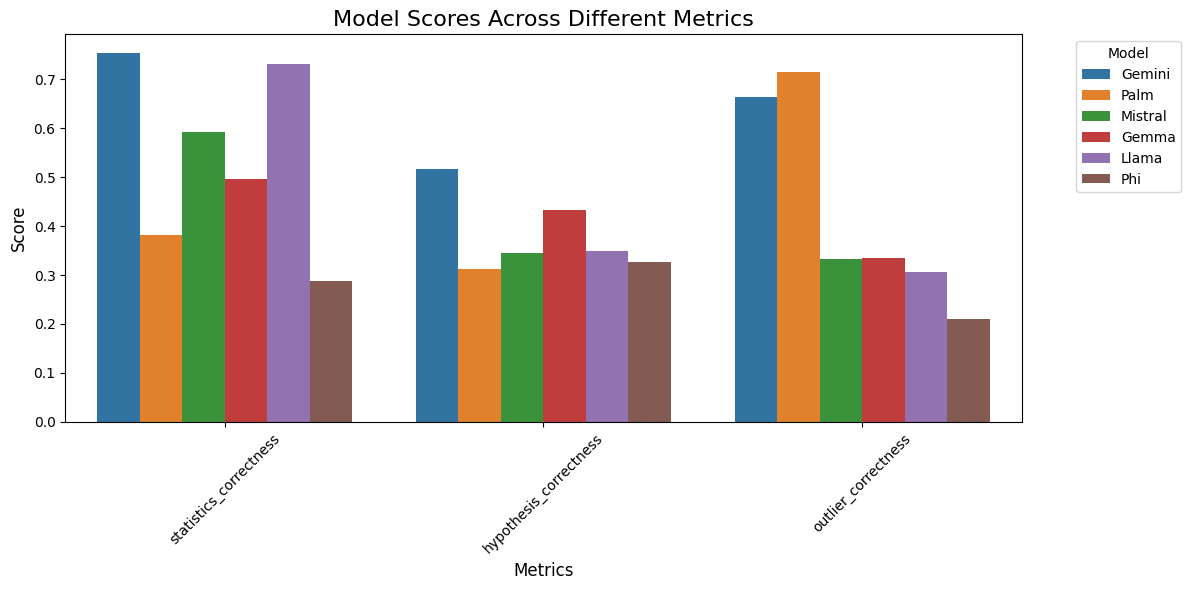

In [36]:
# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=all_scores_df_long)

# Customize the plot
plt.title("Model Scores Across Different Metrics", fontsize=16)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()